In [ ]:
!git submodule update --init --recursive

In [2]:
%cd CubiCasa5k

/kaggle/working/CubiCasa5k


In [ ]:
!pip install lmdb
!pip install svgpathtools
!pip install pycocotools

In [ ]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn.functional as F
from floortrans.loaders.house import House
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from torchvision.ops.boxes import masks_to_boxes, box_area
from mpl_toolkits.axes_grid1 import AxesGrid
from skimage import measure

In [5]:
from numpy import genfromtxt

class FloorplanSVG(Dataset):
    def __init__(self, data_folder, data_file, is_transform=True,
                 augmentations=None, img_norm=True, format='txt',
                 original_size=False, lmdb_folder='cubi_lmdb/'):
        self.img_norm = img_norm
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.get_data = None
        self.original_size = original_size
        self.image_file_name = '/F1_scaled.png'
        self.org_image_file_name = '/F1_original.png'
        self.svg_file_name = '/model.svg'

        if format == 'txt':
            self.get_data = self.get_txt
        if format == 'lmdb':
            self.lmdb = lmdb.open(data_folder+lmdb_folder, readonly=True,
                                  max_readers=8, lock=False,
                                  readahead=True, meminit=False)
            self.get_data = self.get_lmdb
            self.is_transform = False

        self.data_folder = data_folder
        # Load txt file to list
        self.folders = genfromtxt(data_folder + data_file, dtype='str')

    def __len__(self):
        """__len__"""
        return len(self.folders)

    def __getitem__(self, index):
        sample = self.get_data(index)

        if self.augmentations is not None:
            sample = self.augmentations(sample)
            
        if self.is_transform:
            sample = self.transform(sample)

        return sample
    
    def get_wall_bboxes(self, house, coef_width, coef_height):
        wall_labels = torch.tensor(house.walls)
        wall_instance_ids = torch.tensor(house.wall_ids)
        distinct_wall_instance_ids = torch.unique(wall_instance_ids)
        
        distinct_wall_instance_ids = distinct_wall_instance_ids[1:]

        masks = (wall_instance_ids == distinct_wall_instance_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks) # Converting the mask to box coordinates
        
        non_empty_indices = torch.where(box_area(boxes) > 0)
        
        final_masks = masks[non_empty_indices]
        final_boxes = boxes[non_empty_indices]
        
        wall_boxes = []
        
        for i in range(final_boxes.shape[0]):  # Iterate over each bounding box
            wall_bbox = final_boxes[i]
            x_min, y_min, x_max, y_max = wall_bbox.tolist()  # Unpack the specific bounding box
            x_min = int(x_min * coef_width)
            x_max = int(x_max * coef_width)
            y_min = int(y_min * coef_height)
            y_max = int(y_max * coef_height)
            wall_boxes.append(torch.tensor([x_min, y_min, x_max, y_max]))

        return wall_boxes
    
    def get_room_bboxes(self, label_array):
        room_labels = [1, 3, 4, 5, 6, 7, 9, 10, 11]
        room_bboxes = []

        labeled_array, num_features = measure.label(label_array, return_num=True, connectivity=2)

        for feature in range(1, num_features + 1):
            binary_mask = (labeled_array == feature)
            props = measure.regionprops(binary_mask.astype(int))
            
            if props:
                minr, minc, maxr, maxc = props[0].bbox
                bbox = [minc, minr, maxc, maxr] 
                
                

                label = label_array[binary_mask][0]

                if label in room_labels:
                    room_bboxes.append(bbox)

        return room_bboxes

    def get_txt(self, index):
        fplan = cv2.imread(self.data_folder + self.folders[index] + self.image_file_name)
        fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB) 
        height, width, nchannel = fplan.shape
        fplan = np.moveaxis(fplan, -1, 0)

        house = House(self.data_folder + self.folders[index] + self.svg_file_name, height, width)
        
        # Combining them to one numpy tensor
        label = torch.tensor(house.get_segmentation_tensor().astype(np.float32))
        heatmaps = house.get_heatmap_dict()
        coef_width = 1
        if self.original_size:
            fplan = cv2.imread(self.data_folder + self.folders[index] + self.org_image_file_name)
            fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)  # correct color channels
            height_org, width_org, nchannel = fplan.shape
            fplan = np.moveaxis(fplan, -1, 0)
            label = label.unsqueeze(0)
            label = torch.nn.functional.interpolate(label,
                                                    size=(height_org, width_org),
                                                    mode='nearest')
            label = label.squeeze(0)

            coef_height = float(height_org) / float(height)
            coef_width = float(width_org) / float(width)
            for key, value in heatmaps.items():
                heatmaps[key] = [(int(round(x*coef_width)), int(round(y*coef_height))) for x, y in value]
                
        wall_bboxes = self.get_wall_bboxes(house, coef_width, coef_height)
                
        label_np = label.data.numpy()[0]
        room_bboxes = self.get_room_bboxes(label_np)

        img = torch.tensor(fplan.astype(np.float32))

        sample = {'image': img, 'label': label, 'folder': self.folders[index],
                  'heatmaps': heatmaps, 'scale': coef_width, 
                   'wall_bboxes': wall_bboxes, 'room_bboxes': room_bboxes}

        return sample

    def get_lmdb(self, index):
        key = self.folders[index].encode()
        with self.lmdb.begin(write=False) as f:
            data = f.get(key)

        sample = pickle.loads(data)
        return sample

    def transform(self, sample):
        fplan = sample['image']
        fplan = 2 * (fplan / 255.0) - 1

        sample['image'] = fplan

        return sample

In [6]:
rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]

data_folder = '/kaggle/input/cubicasa5k/cubicasa5k/cubicasa5k/'
data_file = 'test.txt'

normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)

data_iter = iter(data_loader)

In [7]:
val = next(data_iter)

junctions = val['heatmaps']
folder = val['folder'][0]

image = val['image']
label = val['label']

wall_bboxes = val['wall_bboxes']
room_bboxes = val['room_bboxes']

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_bboxes(image, room_bboxes, wall_bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    for i, room_bbox in enumerate(room_bboxes):
        x_min, y_min, x_max, y_max = [int(coord) for coord in room_bbox]
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Room {i+1}', color='blue', fontsize=10, verticalalignment='top', horizontalalignment='left')

    for i, wall_bbox in enumerate(wall_bboxes):
        x_min, y_min, x_max, y_max = wall_bbox[0].tolist()
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Wall {i+1}', color='red', fontsize=10, verticalalignment='top', horizontalalignment='left')

    plt.title("Room and Wall Bounding Boxes")
    plt.axis('off') 
    plt.show()

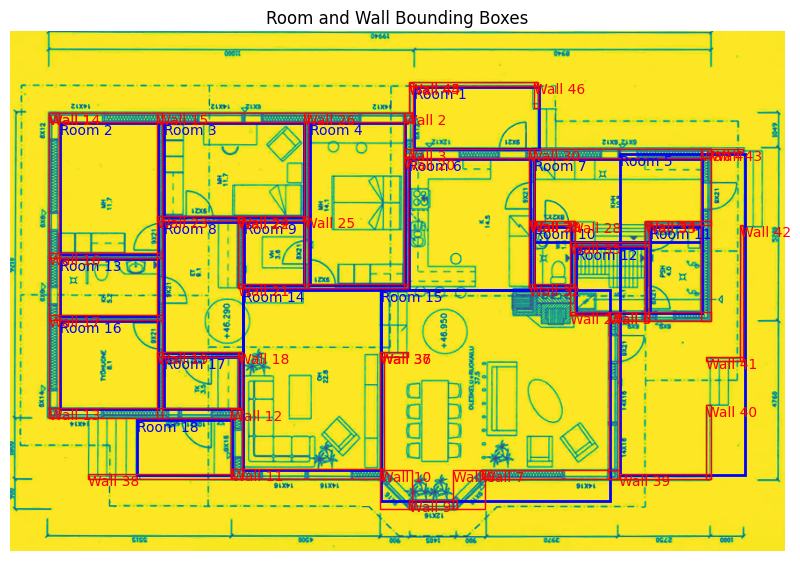

In [9]:
visualize_bboxes(image[0][1], room_bboxes, wall_bboxes)

In [ ]:
!mkdir /coco

In [ ]:
import os
import json
import torch
from tqdm import tqdm

def create_coco_annotations(dataset, output_file, num_images=None):
    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "wall"},
            {"id": 2, "name": "room"}
        ]
    }
    
    annotation_id = 1
    image_id = 1
    
    num_images = num_images if num_images else len(dataset)
    
    for idx in tqdm(range(num_images), desc="Processing Images"):
        sample = dataset[idx]
        image = sample['image']
        wall_bboxes = sample['wall_bboxes']
        room_bboxes = sample['room_bboxes']
        folder = sample['folder']
        scale = sample['scale']
        
        height, width = image.shape[1:]  # Assuming image is in CxHxW format
        
        coco_annotations['images'].append({
            "id": image_id,
            "width": width,
            "height": height,
            "file_name": f"/kaggle/input/cubicasa5k/cubicasa5k/cubicasa5k{folder}F1_original.png"  # Use original image filename
        })
        
        # Process wall bounding boxes
        for wall_bbox in wall_bboxes:
            x_min, y_min, x_max, y_max = wall_bbox.tolist()
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            
            if bbox_width > 0 and bbox_height > 0:
                coco_annotations['annotations'].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": 1,  # Wall category
                    "bbox": [x_min, y_min, bbox_width, bbox_height],
                    "area": bbox_width * bbox_height,
                    "iscrowd": 0
                })
                annotation_id += 1
        
        for room_bbox in room_bboxes:
            x_min, y_min, x_max, y_max = room_bbox
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            
            if bbox_width > 0 and bbox_height > 0:
                coco_annotations['annotations'].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": 2,  # Room category
                    "bbox": [x_min, y_min, bbox_width, bbox_height],
                    "area": bbox_width * bbox_height,
                    "iscrowd": 0
                })
                annotation_id += 1
        
        image_id += 1
    
    with open(output_file, 'w') as f:
        json.dump(coco_annotations, f, indent=4)
    print(f"COCO annotations saved to {output_file}")

In [ ]:
data_folder = '/kaggle/input/cubicasa5k/cubicasa5k/cubicasa5k/'

train_dataset = FloorplanSVG(data_folder, 'train.txt', format='txt', original_size=True)
val_dataset = FloorplanSVG(data_folder, 'val.txt', format='txt', original_size=True)
test_dataset = FloorplanSVG(data_folder, 'test.txt', format='txt', original_size=True)

In [ ]:
create_coco_annotations(train_dataset, '/kaggle/working/CubiCasa5k/coco/train_coco_pt.json')
create_coco_annotations(val_dataset, '/kaggle/working/CubiCasa5k/coco/val_coco_pt.json')
create_coco_annotations(test_dataset, '/kaggle/working/CubiCasa5k/coco/test_coco_pt.json')